This is a (hopefully) simple script that compute the scattering of a plane wave by a penetrable hexagon using the 2D DDA version of the volume integral equation method.

In [1]:
# Import packages
import os
import sys
# FIXME: avoid this sys.path stuff
sys.path.append(os.path.join(os.path.abspath(''), '../../'))
import numpy as np
from scipy.special import hankel1
from scipy.sparse.linalg import LinearOperator, gmres
from analytical import penetrable_circle
from scipy.linalg import toeplitz
import time
from vines.geometry.geometry import shape_2d
from vines.operators.acoustic_operators import get_operator_2d, circulant_embedding
from vines.geometry.geometry import generatedomain2d
from vines.fields.plane_wave import PlaneWave_2d

### Introduction to the volume integral equation method
The boundary value problem we wish to solve is:

Given a complex refractive index $\mu(x)\in\mathbb{C}$, incident wave $u^{\text{inc}}$ and wavenumber $k\in\mathbb{R}$, find the scattered field $u^{\text{sca}}$ such that
$$
    (\nabla^2 + (\mu(x) k)^2)u^{\text{sca}}(x) = -(\nabla^2 + (\mu(x) k)^2)u^{\text{inc}}(x).
$$

The incident wave satisfies the Helmholtz equation with the wavenumber $k$, so the right-hand side can be simplified to yield
$$
    (\nabla^2 + (\mu(x) k)^2)u^{\text{sca}}(x) = -(\mu(x)^2-1) k^2u^{\text{inc}}(x).
$$
This tells us that the scattered field is generated by regions in which $\mu(x)\neq 1$, as we should expect. Let us suppose that we have one closed region $V$ in which $\mu(x)\neq 1$. Then it can be shown that the total field $u:=u^{\text{inc}}+u^{\text{sca}}$ satisfies the following volume integral equation:
$$
    u(x) - k^2\int_{V}G(x,y)(\mu(y)^2-1)u(y)\text{d}y = u^{\text{inc}}(x),
$$
where $G$ is Green's function:
$$
    G(x, y) = \frac{i}{4}H_0^{(1)}(k|x-y|), \quad x\neq y, \quad \text{in two dimensions.}
$$

In [2]:
# Set problem parameters and discretization resolution
ko = 100          # wavenumber
refInd = 1.31     # refractive index
shape = 'hex'    # choose shape (hex, circle, ellipse)
radius = 1       # radius of shape
n_per_lam = 10   # number of points per wavelength
angle = np.pi/8  # Incident wave angle to x-axis
d_inc = np.array([np.cos(angle), np.sin(angle)])

In [3]:
lambda_ext = 2 * np.pi / ko  # wavelength
# Generate grid points (r), indices of interior points (idx), pixel size (dx), shape vertices (verts), interior wavelength (lambda_int)
r, idx, dx, verts, lambda_int = shape_2d('hex', refInd, lambda_ext, radius, n_per_lam)

M, N, _ = r.shape  # number of voxels in x,y directions (M, N, respectively)

In [4]:
# Get Toeplitz operator
a = np.sqrt(dx**2 / np.pi)  # radius of equivalent area circle
toep = get_operator_2d(dx**2, ko, r, a)

In [5]:
# Circulant embedding of Toeplitz matrix (required for FFT matvec)
opCirc = circulant_embedding(toep, M ,N)

In [6]:
# Set up the mu^2-1 matrix, call it MR
mu_sq = np.ones((M, N))
mu_sq[idx] = refInd ** 2
MR = mu_sq - 1

In [7]:
# Define matrix-vector product and corresponding linear operator
from vines.operators.acoustic_matvecs import mvp_2d
mvp = lambda x: mvp_2d(x, opCirc, idx, MR)

A = LinearOperator((M*N, M*N), matvec=mvp)

In [8]:
# Construct circulant approximation of Toeplitz matrix in x-direction
start = time.time()
from vines.precondition.circulant_acoustic import circulant_preconditioner
circ_inv = circulant_preconditioner(toep, M, N, refInd)
end = time.time()
print('Preconditioner assembly time = ', end - start)

Preconditioner assembly time =  7.125205039978027


In [9]:
# Import matrix-vector product with circulant preconditioner and establish preconditioner operator
from vines.precondition.circulant_acoustic import mvp_circ_2d

mvp_prec = lambda x: mvp_circ_2d(x, circ_inv, M, N, idx)
prec = LinearOperator((M*N, M*N), matvec=mvp_prec)

In [10]:
# Assemble right-hand side (u_inc). Use a plane wave.
u_inc = PlaneWave_2d(1, ko, d_inc, r)

# Create an array that equals the incident field inside the scatterer and is zero outside
rhs = np.zeros((M, N), dtype=np.complex128)
rhs[idx] = u_inc[idx]
rhs_vec = rhs.reshape((M*N, 1), order='F')

In [11]:
# Perform iterative solve
it_count = 0

def iteration_counter(x):
    global it_count
    it_count += 1

start = time.time()
solp, info = gmres(A, rhs_vec, M=prec, tol=1e-5, callback=iteration_counter)
end = time.time()
print("The linear system was solved in {0} iterations".format(it_count))
print("Solve time {0} seconds".format(end-start))

The linear system was solved in 157 iterations
Solve time 21.40242624282837 seconds


### Evaluating the field everywhere
The solution we have obtained lives only on the scatterer. In order to evaluate the scatterer field (and hence total field) throughout the domain, we can rearrange our original integral equation to give the following representation for the scattered field:
$$
    u^{\text{sca}}(x) = k^2\int_V G(x, y)(\mu^2(y)-1)u(y)\text{d}y.
$$
That is, we require one matrix-vector product to compute the scattered field.

In [12]:
from vines.operators.acoustic_matvecs import scattered_field
# Scattered field
u_sca = scattered_field(solp, opCirc, M, N, MR)
# Total field
u = u_inc + u_sca

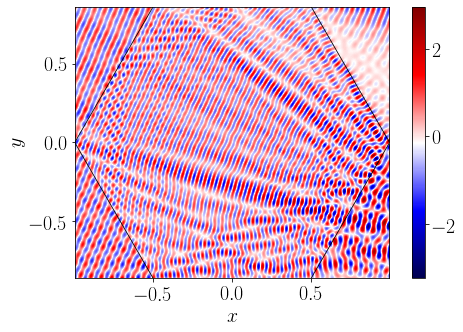

In [13]:
# Plot the field
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
matplotlib.rcParams.update({'font.size': 20})
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fig = plt.figure(figsize=(8, 5))
ax = fig.gca()
plt.imshow(np.real(u.T), extent=[r[0, 0, 0], r[-1, 0, 0], r[0, 0, 1], r[0, -1, 1]],
           cmap=plt.cm.get_cmap('seismic'), interpolation='spline16')

polygon = Polygon(verts, facecolor="none", 
              edgecolor='black', lw=0.8)
plt.gca().add_patch(polygon)

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.colorbar()
plt.show()

So what if we want to evaluate the field over a region that is larger than the original computation domain? This is doable but requires the creation of a new grid and a new (Toeplitz) operator on this grid. For efficiency, it makes sense to ensure that the original grid sits within the new grid and that the pixels are the same size.

In [14]:
# First set up variables for the dimensions of current domain
wx = r[-1, 0, 0] - r[0, 0, 0] + dx
wy = r[0, -1, 1] - r[0, 0, 1] + dx

In [15]:
# Create a larger domain for field evaluation
# Let's make the new domain the original one previous plus a w_extra-sized border
w_extra = lambda_ext * 60
# Now adjust to make sure pixels of new ones will equal the original ones
nn = np.ceil(w_extra / dx)
wx_big = 2 * nn * dx + wx
wy_big = 2 * nn * dx + wy

r_big, M_big, N_big = generatedomain2d(dx, wx_big, wy_big)

In [16]:
# Find pixels inside original computation domain
idx_eval = (r_big[:, :, 0] > r[0, 0, 0] - dx/2) * \
        (r_big[:, :, 0] < r[-1, 0, 0] + dx/2) * \
        (r_big[:, :, 1] > r[0, 0, 1] - dx/2) * \
        (r_big[:, :, 1] < r[0, -1, 1] + dx/2)

In [17]:
# Get Toeplitz operator on new domain
toep_big = get_operator_2d(dx**2, ko, r_big, a)
# Circulant embedding of Toeplitz matrix
opCirc_big = circulant_embedding(toep_big, M_big, N_big)

In [18]:
# Next create the refractive index matrix
mu_sq_big = np.ones((M_big, N_big))
mu_sq_big[idx_eval] = mu_sq.reshape(M*N, 1)[:, 0]
MR_big = mu_sq_big - 1

In [19]:
# Create a new solution matrix that contains the original solution at the correct locations
u_sol_big = np.zeros((M_big, N_big), dtype=np.complex128)
u_sol = solp.reshape(M, N, order='F')
u_sol_big[idx_eval] = u_sol.reshape(M*N, 1)[:, 0]

In [20]:
# Evaluate incident field on new grid
u_inc_big = PlaneWave_2d(1, ko, d_inc, r_big)

In [21]:
# Convert u_sol_big into vector
solp_eval = u_sol_big.reshape((M_big*N_big, 1), order='F')
# Scattered field
u_sca_big = scattered_field(solp_eval, opCirc_big, M_big, N_big, MR_big)
# Total field
u_big = u_inc_big + u_sca_big

In [24]:
# # Plot the 22 degree halo line
# angle_halo = 22 / 180 * np.pi
# point_1 = verts[2, :]
# line_length = 80 * lambda_ext
# point_2 = verts[2, :] + line_length * np.array([np.cos(angle_halo), -np.sin(angle_halo)])

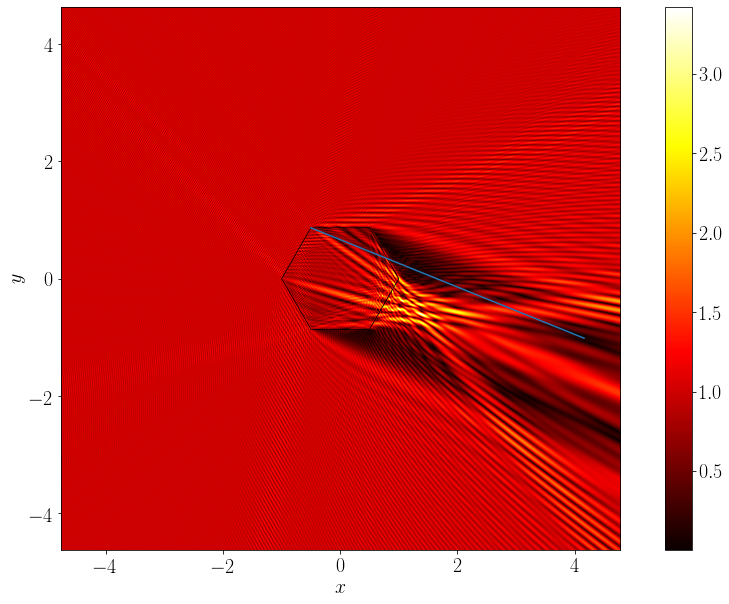

In [25]:
matplotlib.rcParams.update({'font.size': 20})
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fig = plt.figure(figsize=(16, 10))
ax = fig.gca()
plt.imshow(np.abs(u_big.T), extent=[r_big[0, 0, 0], r_big[-1, 0, 0], r_big[0, 0, 1], r_big[0, -1, 1]],
           cmap=plt.cm.get_cmap('hot'), interpolation='spline16')

polygon = Polygon(verts, facecolor="none", 
              edgecolor='black', lw=0.8)
plt.gca().add_patch(polygon)
# plt.plot([point_1[0], point_2[0]], [point_1[1], point_2[1]])

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.colorbar()